# Proyek Klasifikasi Gambar: "Cats vs. Dogs"
- **Nama:** Muhammad Azhar Fikri
- **Email:** muhammadazharfikri990@gmail.com
- **ID Dicoding:** ririee

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os,random,shutil,pathlib, zipfile

import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


from google.colab import files

## Data Preparation

### Data Loading

In [3]:
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

!kaggle datasets download -d moazeldsokyx/dogs-vs-cats

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/moazeldsokyx/dogs-vs-cats
License(s): CC0-1.0
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall("dogs_vs_cats")

os.listdir("dogs_vs_cats/dataset")

['train', 'test', 'validation']

### Data Preprocessing

#### Split Dataset

In [5]:
base_path = "dogs_vs_cats/dataset"

def count_images(path):
    cats = len(os.listdir(os.path.join(path, "cats")))
    dogs = len(os.listdir(os.path.join(path, "dogs")))
    total = cats + dogs
    print(f"{path.split('/')[-1].capitalize()} Set:")
    print(f"  Cat images : {cats}")
    print(f"  Dog images : {dogs}")
    print(f"  Total      : {total}\n")

count_images(os.path.join(base_path, "train"))
count_images(os.path.join(base_path, "validation"))
count_images(os.path.join(base_path, "test"))

Train Set:
  Cat images : 10000
  Dog images : 10000
  Total      : 20000

Validation Set:
  Cat images : 2500
  Dog images : 2500
  Total      : 5000

Test Set:
  Cat images : 6242
  Dog images : 6219
  Total      : 12461



In [6]:
# Generator untuk training, validation, dan testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


## Modelling

In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    mode='min'
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 392ms/step - accuracy: 0.9435 - loss: 0.1463 - val_accuracy: 0.9802 - val_loss: 0.0527
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 251s 386ms/step - accuracy: 0.9707 - loss: 0.0758 - val_accuracy: 0.9822 - val_loss: 0.0485
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 380ms/step - accuracy: 0.9701 - loss: 0.0717 - val_accuracy: 0.9814 - val_loss: 0.0475
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 379ms/step - accuracy: 0.9741 - loss: 0.0643 - val_accuracy: 0.9824 - val_loss: 0.0488
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 380ms/step - accuracy: 0.9774 - loss: 0.0587 - val_accuracy: 0.9816 - val_loss: 0.0490
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 246s 394ms/step - accuracy: 0.9766 - loss: 0.0607 - val_accuracy: 0.9826 - val_loss: 0.0461
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 248s 396ms/step - accuracy: 0.9776 - loss: 0.0562 - val_accuracy: 0.9832 - val_loss: 0.0469
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 389ms/step - accuracy: 0.9760 -

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 402ms/step - accuracy: 0.9749 - loss: 0.0603 - val_accuracy: 0.9834 - val_loss: 0.0452
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 243s 378ms/step - accuracy: 0.9774 - loss: 0.0570 - val_accuracy: 0.9838 - val_loss: 0.0448
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 240s 384ms/step - accuracy: 0.9770 - loss: 0.0562 - val_accuracy: 0.9836 - val_loss: 0.0448
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 240s 384ms/step - accuracy: 0.9774 - loss: 0.0572 - val_accuracy: 0.9836 - val_loss: 0.0448
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 378ms/step - accuracy: 0.9780 - loss: 0.0551 - val_accuracy: 0.9836 - val_loss: 0.0447
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 382ms/step - accuracy: 0.9772 - loss: 0.0597 - val_accuracy: 0.9836 - val_loss: 0.0449


In [9]:
# Evaluasi akurasi pada data latih
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"Akurasi Data Latih: {train_acc:.4f}")

# Evaluasi akurasi pada data uji
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Akurasi Data Uji: {test_acc:.4f}")

Akurasi Data Latih: 0.9836
Akurasi Data Uji: 0.9825


## Evaluasi dan Visualisasi

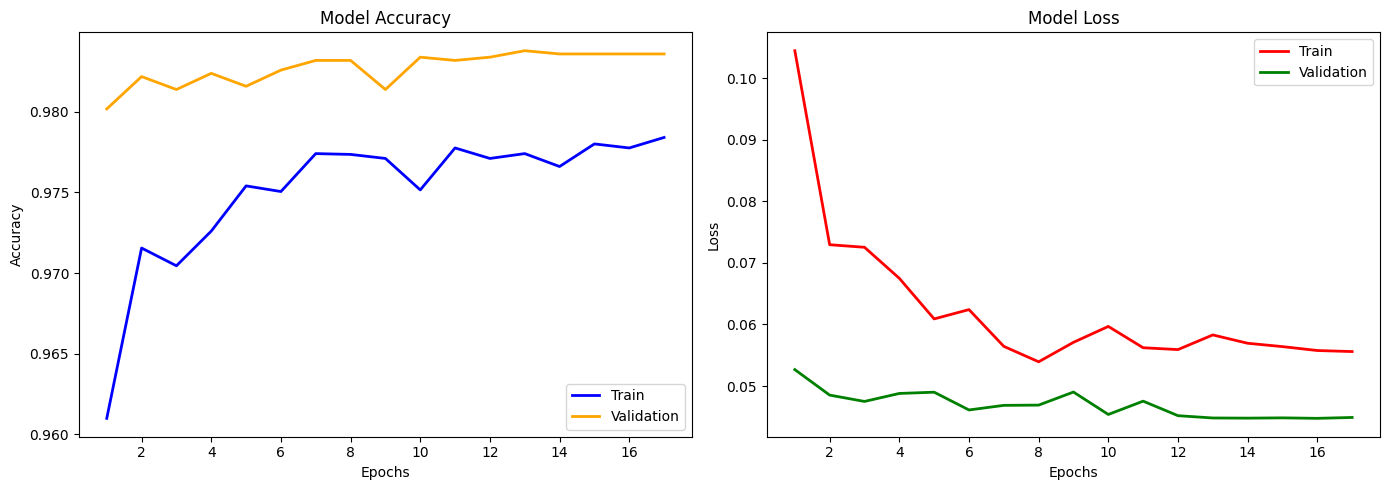

In [10]:
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train', color='blue', linewidth=2)
plt.plot(epochs, val_acc, label='Validation', color='orange', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train', color='red', linewidth=2)
plt.plot(epochs, val_loss, label='Validation', color='green', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [11]:
tf.saved_model.save(model, 'saved_model')

In [12]:
model.save("saved_model.h5")

In [13]:
!tensorflowjs_converter --input_format=keras saved_model.h5 saved_model_tfjs

2025-04-18 21:09:58.884675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745010598.921777   24282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745010598.929719   24282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [14]:
shutil.make_archive('saved_model_tfjs', 'zip', 'saved_model_tfjs')

'/content/saved_model_tfjs.zip'

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

label = ['Cat', 'Dog']
with open('label.txt', 'w') as f:
    f.write('\n'.join(label))

Saved artifact at '/tmp/tmp4olc0o3f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139628041139216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139625424691344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139625424691536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139628041139408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139628041139984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139628041139600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139625424690192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139625424685392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139625424691728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139625424691920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1396254246

In [16]:
!pip freeze > requirements.txt

## Inference (Optional)

Saving meng.jpeg to meng.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


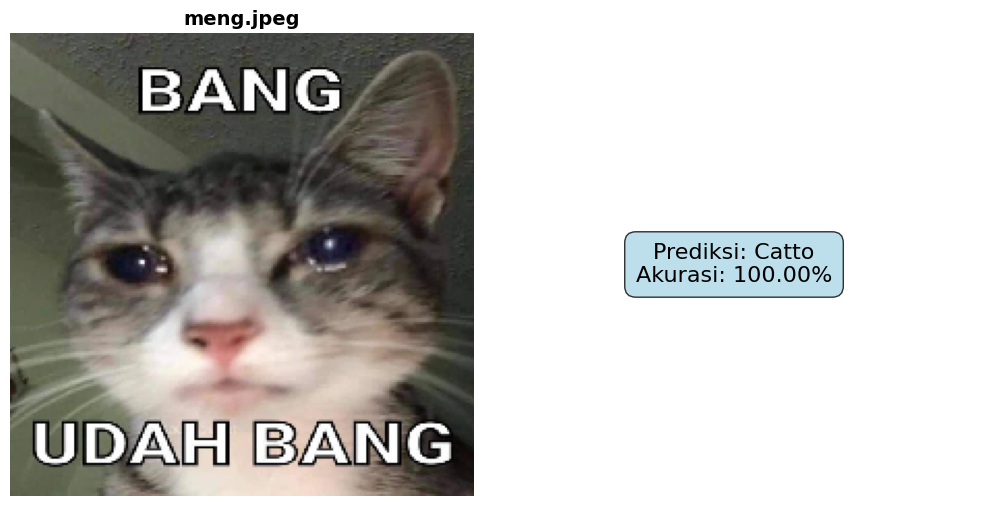

In [17]:
model = load_model("saved_model.h5")

uploaded = files.upload()

for fn in uploaded.keys():
    img_bytes = uploaded[fn]
    img = image.load_img(io.BytesIO(img_bytes), target_size=(224, 224))

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    confidence = model.predict(img_array)[0][0]
    predicted_class = "Doge" if confidence > 0.5 else "Catto"
    confidence_pct = max(confidence, 1 - confidence) * 100

    plt.figure(figsize=(10, 5))

    # Tampilkan gambar
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"{fn}", fontsize=14, fontweight='bold')
    plt.axis('off')

    # Tampilkan hasil prediksi
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5,
             f"Prediksi: {predicted_class}\nAkurasi: {confidence_pct:.2f}%",
             fontsize=16,
             ha='center', va='center',
             bbox=dict(facecolor='lightblue', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
print(f"\nHasil: {predicted_class} ({confidence_pct:.1f}% akurat)")


Hasil: Catto (100.0% akurat)
